# Gated Recurrent Unit (GRU)

Recall that the hidden state in the LSTM cell is essentially the internal state filtered based on the current input (i.e. with the output gate $\boldsymbol{\Gamma}^o_t$). 
Modifications such as [peephole connections](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43905.pdf) have been proposed to include the pure internal cell state in the computation. A further simplification is the **GRU** {cite}`gru` which combines the feedback mechanism into a single hidden state vector that is appropriately gated. 
This significantly reduces the number of parameters compared to LSTM with similar performance.

## Gating mechanism

Similar to an LSTM cell, GRU uses gates to control update and reset of memory over time:

| Gate | Symbol | Controls | 
| :--: | :--: | :--: |
| Reset | $\boldsymbol{\Gamma}^r$  | How much of the previous state is incorporated into the new state | 
| Update | $\boldsymbol{\Gamma}^z$  |  How much of the old state is *retained*, versus the candidate state |


This is similar to the LSTM cell with the input gate corresponding to the reset gate and the forget gate corresponding to the update gate. There is no output gate; the current state is calculated as a weighted average of the previous state and the candidate state. 

## GRU equations

GRU computation is defined as follows. Let $h$ be the width of the GRU and $B$ be the batch size. Then all entries of the gates in $(0, 1) \subset \mathbb{R}$ which can be interpreted as a $B \times h$ smooth switch:

$$
\begin{aligned}
{\boldsymbol{\Gamma}^r_t} & =\sigma(\boldsymbol{\mathsf{X}}_t \boldsymbol{\mathsf{U}}^{{r}}+\boldsymbol{\mathsf{H}}_{t-1} \boldsymbol{\mathsf{W}}^{{r}}+\boldsymbol{\mathsf{b}}^{{r}}) \\
{\boldsymbol{\Gamma}^z_t} & =\sigma(\boldsymbol{\mathsf{X}}_t \boldsymbol{\mathsf{U}}^{{z}}+\boldsymbol{\mathsf{H}}_{t-1} \boldsymbol{\mathsf{W}}^{{z}}+\boldsymbol{\mathsf{b}}^{{z}}) 
\end{aligned}
$$

The hidden state ${\boldsymbol{\mathsf{C}}}_t$ with shape $B \times h$ is updated as

$$
\begin{aligned}
\tilde{\boldsymbol{\mathsf{H}}}_t &= \tanh(\boldsymbol{\mathsf{X}}_t \boldsymbol{\mathsf{U}}^{{h}}+(\boldsymbol{\Gamma}^r_t \odot \boldsymbol{\mathsf{H}}_{t-1}) \boldsymbol{\mathsf{W}}^{{h}}+\boldsymbol{\mathsf{b}}^{{h}}) \\
\boldsymbol{\mathsf{H}}_t &= {\boldsymbol{\Gamma}^z_t} \odot \boldsymbol{\mathsf{H}}_{t - 1} + (1 - {\boldsymbol{\Gamma}^z_t}) \odot \tilde{\boldsymbol{\mathsf{H}}}_t
\end{aligned}
$$

where $\tilde{\boldsymbol{\mathsf{H}}}_t$ is called the *candidate hidden state*. Applying $\tanh$ ensures that elements of ${\boldsymbol{\mathsf{H}}}_t$ are in $(-1, 1).$  The computation is illustrated in {numref}`05-gru`:

<br>

```{figure} ../../../img/nn/05-gru.svg
---
width: 600px
name: 05-gru
align: center
---
Computing the hidden state in a GRU model. [Source](https://www.d2l.ai/chapter_recurrent-modern/gru.html#hidden-state)
```

First, let us look at the reset gate. When ${\boldsymbol{\Gamma}^r_t} = 1$, the entire hidden state is used to calculate the candidate hidden state. On the other hand, if ${\boldsymbol{\Gamma}^r_t} = 0$, then the hidden state is reset and we start with a candidate state that depends precisely on the current input. However, the update gate can still ignore the candidate state with ${\boldsymbol{\Gamma}^z_t} = 1$, so that past inputs will potentially still have an effect on future outputs, i.e. $\boldsymbol{\mathsf{h}}_t \approx \boldsymbol{\mathsf{h}}_{t - 1}.$  Similarly, the GRU can accrue information across many time steps this way by keeping the reset and update gates open. Once it closes, the accumulated information in the candidate state takes effect. In general, this is how long-term dependencies are handled by the unit. The gradient for $\boldsymbol{\mathsf{h}}_{t-1}$ can be calculated by following nodes that depend on it, there are four such paths, but one path 
involving $\frac{\partial{\boldsymbol{\mathsf{h}}_t}}{\partial{\boldsymbol{\mathsf{h}}_{t-1}}}$ only involves scaling with ${\boldsymbol{\Gamma}^z_t} \, \odot$ instead of matrix multiplication.

<br>

## Code implementation

In [1]:
from chapter import *

In [2]:
%%save
class GRU(nn.Module):
    def __init__(self, inputs_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.inputs_dim = inputs_dim
        self.R = nn.Linear(inputs_dim + hidden_dim, hidden_dim)
        self.Z = nn.Linear(inputs_dim + hidden_dim, hidden_dim)
        self.G = nn.Linear(inputs_dim + hidden_dim, hidden_dim)
        
    def forward(self, x, h=None):
        x = x.transpose(0, 1)  # (B, T, d) -> (T, B, d)
        T, B, d = x.shape
        assert d == self.inputs_dim
        
        if h is None:
            h = torch.zeros(B, self.hidden_dim, device=x.device)
        else:
            assert h.shape == (B, self.hidden_dim)

        outs = []
        for t in range(T):
            gate_input = torch.cat([x[t], h], dim=1)
            r = torch.sigmoid(self.R(gate_input))
            z = torch.sigmoid(self.Z(gate_input))
            g = torch.tanh(self.G(torch.cat([x[t], r * h], dim=1)))
            h = z * h + (1 - z) * g
            outs.append(h)

        outs = torch.stack(outs)
        outs = outs.transpose(0, 1)
        return outs, h

class GRU(nn.Module):
    def __init__(self, inputs_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.inputs_dim = inputs_dim
        self.R = nn.Linear(inputs_dim + hidden_dim, hidden_dim)
        self.Z = nn.Linear(inputs_dim + hidden_dim, hidden_dim)
        self.G = nn.Linear(inputs_dim + hidden_dim, hidden_dim)
        
    def forward(self, x, h=None):
        x = x.transpose(0, 1)  # (B, T, d) -> (T, B, d)
        T, B, d = x.shape
        assert d == self.inputs_dim
        
        if h is None:
            h = torch.zeros(B, self.hidden_dim, device=x.device)
        else:
            assert h.shape == (B, self.hidden_dim)

        outs = []
        for t in range(T):
            gate_input = torch.cat([x[t], h], dim=1)
            r = torch.sigmoid(self.R(gate_input))
            z = torch.sigmoid(self.Z(gate_input))
            g = torch.tanh(self.G(torch.cat([x[t], r * h], dim=1)))
            h = z * h + (1 - z) * g
            outs.append(h)

        outs = torch.stack(outs)
        outs = outs.transpose(0, 1)
        return outs, h

Shapes test:

In [3]:
B, T, d, h = 32, 5, 10, 20
x = torch.randn(B, T, d)
gru = GRU(d, h)
outs, H = gru(x)    # same with PyTorch: 
                    # https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

assert outs.shape == (B, T, h)
assert H.shape == (B, h)

<br>

### Model training

In [4]:
from torch.utils.data import random_split

tm = TimeMachine()
corpus, vocab = tm.build()
T = 30
BATCH_SIZE = 128

dataset = SequenceDataset(corpus, seq_len=T, vocab_size=len(vocab))
train_ds, valid_ds = random_split(dataset, [0.80, 0.20])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True)    # also sampled

len(train_loader) * 128 * T, len(valid_loader) * 128 * T

(4181760, 1048320)

In [5]:
from tqdm.notebook import tqdm

DEVICE = "cpu"
LR = 0.01
EPOCHS = 5
MAX_NORM = 1.0

model = LanguageModel(GRU)(len(vocab), 64, len(vocab))
model.to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=LR)

train_losses = []
valid_losses = []
for e in tqdm(range(EPOCHS)):
    for t, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x, y = x.to(DEVICE), y.to(DEVICE)
        loss = train_step(model, optim, x, y, MAX_NORM)
        train_losses.append(loss)

        if t % 5 == 0:
            xv, yv = next(iter(valid_loader))
            xv, yv = xv.to(DEVICE), yv.to(DEVICE)
            valid_losses.append(valid_step(model, xv, yv))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

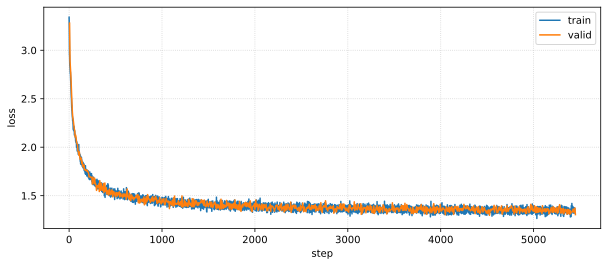

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="train")
plt.plot(np.array(range(1, len(valid_losses) + 1)) * 5, valid_losses, label="valid")
plt.grid(linestyle="dotted", alpha=0.6)
plt.ylabel("loss")
plt.xlabel("step")
plt.legend();

In [7]:
np.array(valid_losses[-50:]).mean()

1.3460165071487427

<br>

### Text generation

In [8]:
textgen = TextGenerator(model, vocab, device="cpu")
s = [textgen.predict("thank y", num_preds=2, temp=0.4) for i in range(20)]
(np.array(s) == "thank you").mean()

1.0

In [9]:
warmup = "mr williams i underst"
text = []
temp = []
for i in range(1, 6):
    t = 0.20 * i
    s = textgen.predict(warmup, num_preds=100, temp=t)
    text.append(s)
    temp.append(t)

In [10]:
import pandas as pd
from IPython.display import display
pd.set_option("display.max_colwidth", None)
df = pd.DataFrame({"temp": [f"{t:.1f}" for t in temp], "text": text})
df = df.style.set_properties(**{"text-align": "left"})
display(df)

,temp,text
0,0.2,mr williams i understood what so the time traveller and the remark the time traveller and the bronze contrape the morlock
1,0.4,mr williams i understorly and the same to the time machine and the reconding and the morlocks and the some down one passi
2,0.6,mr williams i understood the thing it saw the soft in the time machine was really i found the same that i said see the mo
3,0.8,mr williams i understood i put forcul there had corritangs myself by the following to sat a reddetry which over a morl of
4,1.0,mr williams i understade here to fumenot wild laughed when it passed along a matere or jointly from the thing to the mech
